# Building a Neural Network from Scratch

With the increasing number of machine learning libraries available, it is alwasy good to back to the basic and implement neural networks from scratch.

### Import Dependencies

In [1]:
import sys
import math
import csv
import random 
import time
import numpy
import gzip
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#### Miscellaneous functions
def Sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+numpy.exp(-z))

def SigmoidPrime(z):
    """Derivative of the sigmoid function."""
    return Sigmoid(z)*(1-Sigmoid(z))

# Neural Network Class

In [3]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        #Initialize Weights & Biases
        self.biases = [numpy.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [numpy.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def Feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = Sigmoid(numpy.dot(w, a)+b)
        return a

    def Train(self, trainingData, testingData, epoch, batchSize, learningRate):

        trainingResults = [[],[]]
        testingResults = [[],[]]
        
        testDataSize = len(testingData)
        trainDataSize = len(trainingData)
        for i in range(epoch):

            random.shuffle(trainingData)
            for j in range(0, trainDataSize, batchSize):

                nabla_b = [numpy.zeros(b.shape) for b in self.biases]
                nabla_w = [numpy.zeros(w.shape) for w in self.weights]
                
                miniBatchSize = 0
                
                for x, y in trainingData[j:j+batchSize]:
                    delta_nabla_b, delta_nabla_w = self.Backpropagation(x, y)

                    nabla_b = [(delta_nabla_b_row + nabla_b_row) for delta_nabla_b_row, nabla_b_row in zip(delta_nabla_b, nabla_b)]
                    nabla_w = [(delta_nabla_w_row + nabla_w_row) for delta_nabla_w_row, nabla_w_row in zip(delta_nabla_w, nabla_w)]
                
                    miniBatchSize = miniBatchSize + 1

                self.weights = [w_layer - (learningRate/miniBatchSize)*nw_layer for w_layer, nw_layer in zip(self.weights, nabla_w)]
                self.biases = [b_layer -(learningRate/miniBatchSize)*nb_layer for b_layer, nb_layer in zip(self.biases, nabla_b)]
                
            trainingResult = self.Evaluate(trainingData)
            testingResult = self.Evaluate(testingData)
            
            trainingResults[0].append(trainingResult[0])
            trainingResults[1].append(trainingResult[1])
            
            testingResults[0].append(testingResult[0])
            testingResults[1].append(testingResult[1])
            
            print ("Epoch {0} - Train: {1} / {2} | Test: {3} / {4} ".format(i, trainingResult[0], trainDataSize, testingResult[0], testDataSize))
            
        return trainingResults, testingResults

    def Backpropagation(self, x, y):
        #Change in Biases
        nabla_b = [numpy.zeros(b.shape) for b in self.biases]

        #Change in Weights
        nabla_w = [numpy.zeros(w.shape) for w in self.weights]

        activations = []
        activations.append(x)
        zs = []

        for index, (weights, bias) in enumerate(zip(self.weights, self.biases)):
            individualWeightedSum = numpy.dot(weights, activations[index]) + bias
            zs.append(individualWeightedSum)
            activation = Sigmoid(individualWeightedSum)
            activations.append(activation)

        sigmodPrime = SigmoidPrime(zs[-1])
        delta = self.CostDerivative(activations[-1], y) * sigmodPrime 

        nabla_b[-1] = delta
        nabla_w[-1] = numpy.dot(delta, activations[-2].transpose())

        for l in range(2, len(self.weights)):
            z = zs[-l]
            sp = SigmodPrime(z)
            delta = numpy.dot(self.weights[-l+1], delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = numpy.dot(delta, activations[-l-1].transpose())

        return (nabla_b, nabla_w)

    def Evaluate(self, data):
        #Get all results
        results = [(self.Feedforward(x), y) for (x, y) in data]
        
        #Get number of correct results
        numberOfCorrectResults = sum(int(numpy.argmax(x) == numpy.argmax(y)) for (x, y) in results)
        
        #Calculate Mean Square Error
        sumError = [numpy.subtract(x, y) for (x, y) in results]
        sumSquareError = [numpy.square(x) for x in sumError]
        meanSquareError = sum(numpy.sum(x) for x in sumSquareError)/len(data)
        
        return numberOfCorrectResults, meanSquareError

    def CostDerivative(self, output_activations, y):
        return (output_activations-y)


# Data Loader Class

In [4]:
def LoadData(directory):
    
    #Training Data
    trainingDataFilePath = "train-images-idx3-ubyte.gz"
    trainingLabelsFilePath = "train-labels-idx1-ubyte.gz"
    
    #Testing Data
    testingDataFilePath = "t10k-images-idx3-ubyte.gz"
    testingLabelFilePath = "t10k-labels-idx1-ubyte.gz"
    
    trainingDataFilePath = os.path.join(directory, trainingDataFilePath)
    trainingLabelsFilePath = os.path.join(directory, trainingLabelsFilePath)

    testingDataFilePath = os.path.join(directory, testingDataFilePath)
    testingLabelFilePath = os.path.join(directory, testingLabelFilePath)
    
    trainingData = LoadImagesAndLables(trainingDataFilePath, trainingLabelsFilePath)
    testingData = LoadImagesAndLables(testingDataFilePath, testingLabelFilePath)
    
    return trainingData, testingData

def LoadImagesAndLables(imageFilePath, labelFilePath):
    images = LoadImages(imageFilePath)
    labels = LoadLabels(labelFilePath)
    return zip(images, labels)

def LoadLabels(filePath):
    labels = gzip.open(filePath,'r')
    labels.read(8)
    
    labelVectors = []
    for chunk in iter(lambda: labels.read(1), b''):
        label = int.from_bytes(chunk, byteorder='big')
        labelVector = numpy.zeros((10,1))
        labelVector[label] = 1.0
        labelVectors.append(labelVector)  
        
    return labelVectors
    
def LoadImages(filePath):
    images = gzip.open(filePath,'r')
    images.read(8)
    
    #Get Image Height and Width
    imageHeight = int.from_bytes(images.read(4), byteorder='big')
    imageWidth = int.from_bytes(images.read(4), byteorder='big')
    
    imageVectors = []
    for chunk in iter(lambda: images.read(imageHeight*imageWidth), b''):
        image = numpy.frombuffer(chunk, dtype=numpy.uint8).astype(numpy.float32)
        image = image[:,None]
        imageVectors.append(image)
        
    return imageVectors

In [5]:
#Get Training and Testing Data
trainingData, testingData = LoadData("Data")

trainingData = list(trainingData)
testingData = list(testingData)

# Displaying Training Images

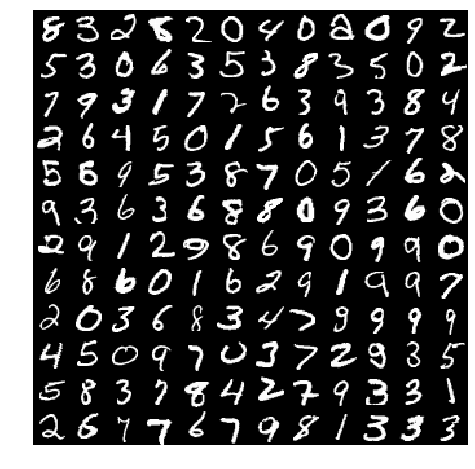

In [6]:
square = 12
indexes = random.sample(range(len(trainingData)), square* square)
images = [numpy.array(trainingData[i][0], dtype='uint8') for i in indexes]
for image in images:
    image.resize(28,28) 
images = [Image.fromarray(i) for i in images]    

total_square = square * 28

compImage = Image.new('L', (total_square,total_square))

x_offset = 0
y_offset = 0
for im in images:
    compImage.paste(im, (x_offset,y_offset))
    x_offset += im.size[0]
    if(x_offset == square*28):
        x_offset = 0 
        y_offset += im.size[0]

plt.figure(figsize=(8,8)) 
plt.axis('off')
plt.imshow(compImage)

# Train Model

In [7]:
#Create Network
network = Network([784, 200, 10])

#Train Model
batchSize = 128
epochs = 10
learningRate = .5
trainingResults, testingResults = network.Train(trainingData, testingData, epochs, batchSize, learningRate)

Epoch 0 - Train: 6909 / 60000 | Test: 1173 / 10000 
Epoch 1 - Train: 7642 / 60000 | Test: 1277 / 10000 
Epoch 2 - Train: 8008 / 60000 | Test: 1320 / 10000 
Epoch 3 - Train: 8382 / 60000 | Test: 1388 / 10000 
Epoch 4 - Train: 8573 / 60000 | Test: 1414 / 10000 
Epoch 5 - Train: 8859 / 60000 | Test: 1459 / 10000 
Epoch 6 - Train: 8944 / 60000 | Test: 1473 / 10000 
Epoch 7 - Train: 9089 / 60000 | Test: 1495 / 10000 
Epoch 8 - Train: 9165 / 60000 | Test: 1504 / 10000 
Epoch 9 - Train: 9281 / 60000 | Test: 1515 / 10000 


# Plott Error and % Correct

<Figure size 432x288 with 0 Axes>

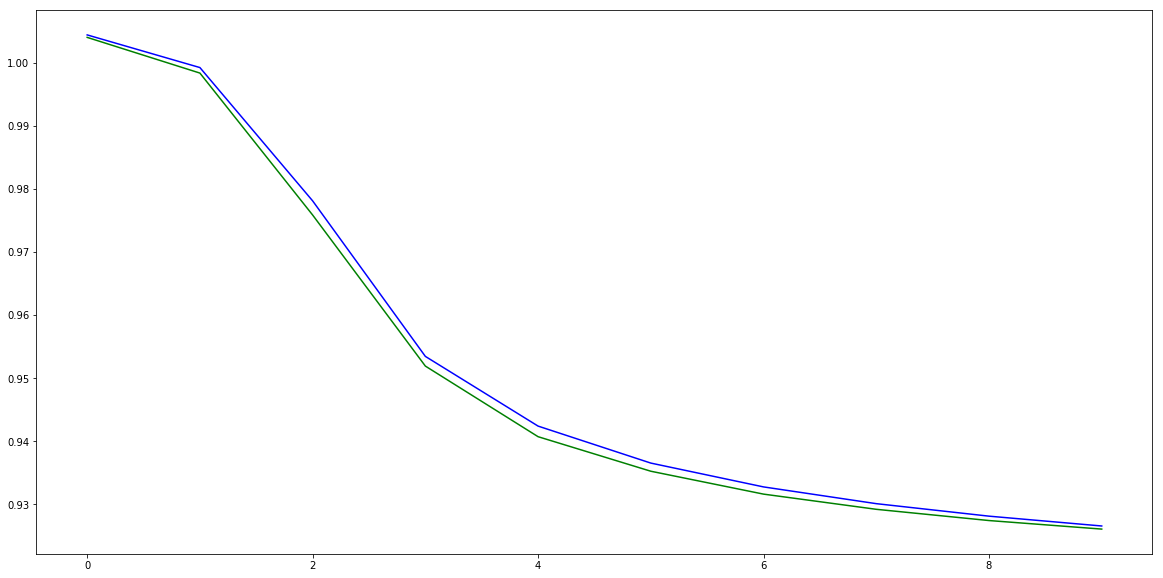

In [8]:
plt.clf()
plt.figure(figsize=(20,10)) 
plt.plot(trainingResults[1], color="b")
plt.plot(testingResults[1], color="g")
plt.show()

<Figure size 432x288 with 0 Axes>

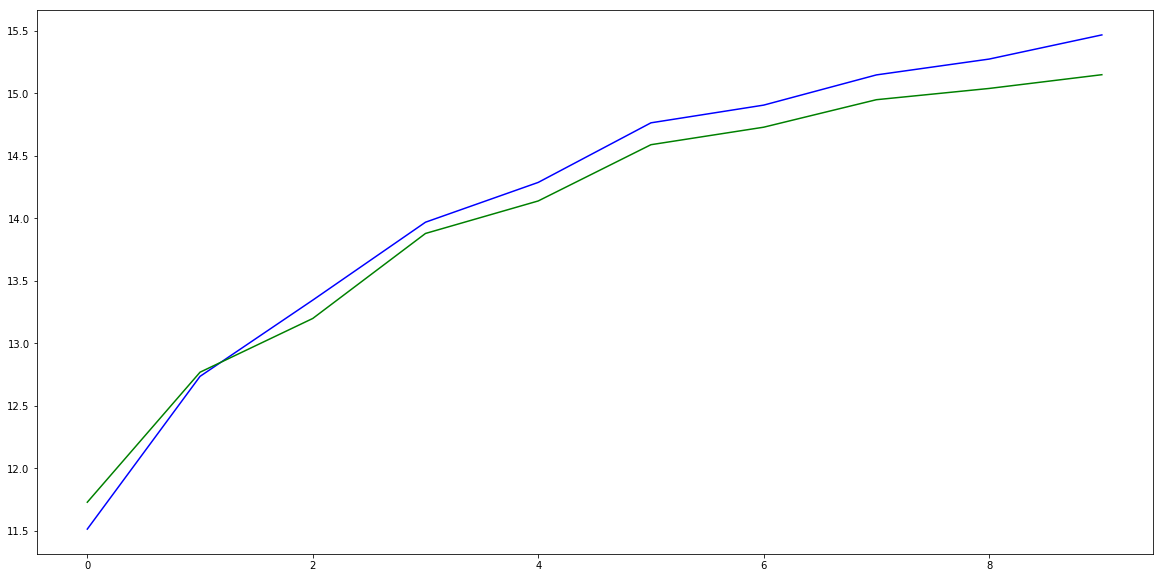

In [9]:
plt.clf()
plt.figure(figsize=(20,10)) 
plt.plot([x/len(trainingData)*100 for x in trainingResults[0]], color="b")
plt.plot([x/len(testingData)*100 for x in testingResults[0]], color="g")
plt.show()